In [3]:
import numpy as np
import pandas as pd
import math
import random
import time
from statistics import mean
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

#Definición de Dataset Inicial

In [14]:
x = [
    [1,2],
    [1,3],
    [2,3],
    [2,4],
    [3,2],
    [3,5],
    [4,1],
    #A partir de aqui es relleno para el mini-batch
    [1,2],
    [1,3],
    [2,3],
    [2,4],
    [3,2],
    [3,5],
    [4,1]
]
y = [1.03,-1.44,4.53,2.24,13.27,5.62,21.53,#A partir de aqui es relleno para el mini-batch
     1.03,-1.44,4.53,2.24,13.27,5.62,21.53]

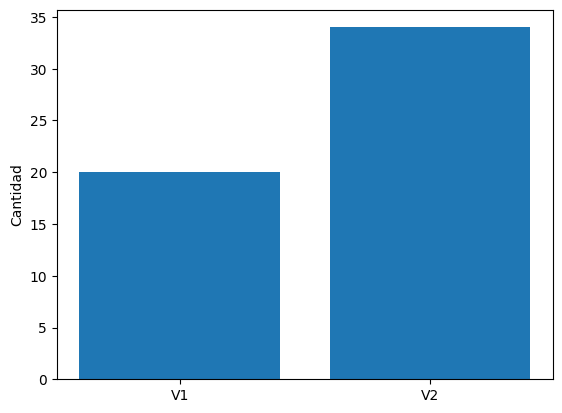

In [32]:

# Datos
valores = [20, 34]
etiquetas = ['V1', 'V2']

# Crear gráfico de barras
plt.bar(etiquetas, valores)

# Añadir etiquetas
plt.xlabel('')
plt.ylabel('Cantidad')

# Mostrar gráfico
plt.show()


#Definición de métodos utilizados

In [57]:
def signo(x):
  if x>=0:
    return 1
  else:
    return -1
def predict(modelo,x):
  if type(x[0]) == list:
    pred_v = []
    for x_it in x:
      pred = modelo[len(modelo)-1]
      for i in range(len(modelo)-1):
        pred+= modelo[i]*x_it[i]
      pred_v.append(pred)
    return pred_v
  else:
    pred = modelo[len(modelo)-1]
    for i in range(len(modelo)-1):
      pred+= modelo[i]*x[i]

    return pred

def MAE(modelo,x,y):
  pred = predict(modelo,x)
  errs =[e1 - e2 for e1, e2 in zip(y,pred)]
  abs_v = [abs(ele) for ele in errs]

  return mean(abs_v)
def MSE(modelo,x,y):
  pred = predict(modelo,x)
  errs =[e1 - e2 for e1, e2 in zip(y,pred)]
  squ_v = [(ele)**2 for ele in errs]

  return mean(squ_v)

def MSE_GRAD(modelo,x,errs,w_it,l_rate,reg_term,Lasso,Ridge):
  if w_it < len(modelo)-1:
        #len(modelo)-1 porque el último peso es el sesgo y se ajusta
        #de forma distinta
        #Aqui se ajustan todos los pesos menos el bias

        #Cálculo del Σ((Ŷ-Y)*Xji)
        for er in range(len(errs)):
          errs[er]= errs[er]*x[er][w_it]
        if Lasso:
          modelo[w_it] = modelo[w_it]-1*(2*l_rate)*mean(errs)+reg_term*signo(modelo[w_it])
        elif Ridge:
          modelo[w_it] = modelo[w_it]-1*(2*l_rate)*mean(errs)+2*reg_term*modelo[w_it]
        else:
          modelo[w_it] = modelo[w_it]-1*(2*l_rate)*mean(errs)

  else:
    #Aqui se ajusta el bias
    modelo[w_it] = modelo[w_it] -1*(2*l_rate*mean(errs) )

def MAE_GRAD(modelo,x,errs,w_it,l_rate,reg_term,Lasso,Ridge):
  if w_it < len(modelo)-1:
        for er in range(len(errs)):
          errs[er]= signo(errs[er])*x[er][w_it]
        if Lasso:
          modelo[w_it] = modelo[w_it]-1*(l_rate)*mean(errs)+reg_term*signo(modelo[w_it])
        elif Ridge:
          modelo[w_it] = modelo[w_it]-1*(l_rate)*mean(errs)+2*reg_term*modelo[w_it]
        else:
          modelo[w_it] = modelo[w_it]-1*(l_rate)*mean(errs)
        #Aqui se ajusta el bias
  else:
    errs = [signo(x) for x in errs]
    modelo[w_it] = modelo[w_it] -1*(l_rate*mean(errs) )

def generate_mini_batch(x, y, batch_percentage):
  tam_mini_batch = math.trunc(len(x)*batch_percentage)
  mini_batch_x = []
  mini_batch_y = []
  x_copy = x.copy()
  y_copy = y.copy()

  while len(x_copy)>0:
    it_mini_batchx = []
    it_mini_batchy = []
    while len(it_mini_batchx)<tam_mini_batch:
      index = random.randint(0,len(x_copy)-1)
      it_mini_batchx.append(x_copy[index])
      it_mini_batchy.append(y_copy[index])
      x_copy.pop(index)
      y_copy.pop(index)
    mini_batch_x.append(it_mini_batchx)
    mini_batch_y.append(it_mini_batchy)

  return mini_batch_x,mini_batch_y

def linear_regression(modelo,x,y,n_it,l_rate,reg_term,func_ajuste, Lasso=False, Ridge=False, minibatch_mode=False, batch_percentage=None):
  for _ in range(n_it):
    if not minibatch_mode:
      errs = []
      pred = predict(modelo,x)
      errs = [e1 - e2 for e1, e2 in zip(pred,y)]

      for w_it in range(len(modelo)):
        errs_it = errs.copy()
        func_ajuste(modelo,x,errs_it,w_it,l_rate,reg_term,Lasso,Ridge)
    else:
      batch_x, batch_y = generate_mini_batch(x, y, batch_percentage)
      for a, b in zip(batch_x, batch_y):
        errs = []
        pred = predict(modelo,a)
        errs = [e1 - e2 for e1, e2 in zip(pred,b)]

        for w_it in range(len(modelo)):
          errs_it = errs.copy()
          func_ajuste(modelo,a,errs_it,w_it,l_rate,reg_term,Lasso,Ridge)
  return modelo

#Métodos para la realización de gráficas
def bar_plot(etiquetas,valores,ylabel,xlabel='',log=False):
  plt.bar(etiquetas, valores)
  if log:
    plt.yscale('log')

  # Añadir etiquetas
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)

  # Mostrar gráfico
  plt.show()

#Prueba de los algoritmos de descenso del gradiente tanto con MAE como con MSE.

In [15]:
modelo = [1,1,1]
print('Ajuste con MSE')
print('Error inicial -> ',MSE(modelo,x,y))
start = time.time()
linear_regression(modelo,x,y,20000,0.001,0,MSE_GRAD)
tiempo = (time.time()-start)*1000
print('Error final -> ',MSE(modelo,x,y))
print(f'Tiempo de ejecución -> {tiempo} ms')
print(modelo)

modelo = [1,1,1]
print('\nAjuste con MAE')
print('Error inicial -> ',MAE(modelo,x,y))
start = time.time()
linear_regression(modelo,x,y,20000,0.001,0, MAE_GRAD)
tiempo = (time.time()-start)*1000
print('Error final -> ',MAE(modelo,x,y))
print(f'Tiempo de ejecución -> {tiempo} ms')
print(modelo)

Ajuste con MSE
Error inicial ->  54.367314285714286
Error final ->  0.008417023656379178
Tiempo de ejecución -> 2851.8011569976807 ms
[6.007147684087246, -2.489069952946704, 0.06976974256473045]

Ajuste con MAE
Error inicial ->  5.974285714285714
Error final ->  0.05959183673453323
Tiempo de ejecución -> 1258.0831050872803 ms
[6.008285714285928, -2.4745714285724416, -0.02685714285709419]


#Prueba de los algoritmos de descenso del gradiente tanto con MAE como con MSE comparación usando el modo batch y mini batch.

Ajuste usando batch
Ajuste con MSE
Error inicial ->  54.367314285714286
Error final ->  0.008417023656379178
Tiempo de ejecución -> 3717.7584171295166 ms
[6.007147684087246, -2.489069952946704, 0.06976974256473045]

Ajuste con MAE
Error inicial ->  5.974285714285714
Error final ->  0.05959183673453323
Tiempo de ejecución -> 1447.2169876098633 ms
[6.008285714285928, -2.4745714285724416, -0.02685714285709419]

Ajuste usando minibatch
Ajuste con MSE
Error inicial ->  54.367314285714286
Error final ->  0.007876918106696558
Tiempo de ejecución -> 7681.180477142334 ms
[6.0241416347997925, -2.474917145561534, -0.015324048145875206]

Ajuste con MAE
Error inicial ->  5.974285714285714
Error final ->  0.06357142857182661
Tiempo de ejecución -> 6607.516050338745 ms
[6.010000000000314, -2.470999999999887, -0.02900000000000101]


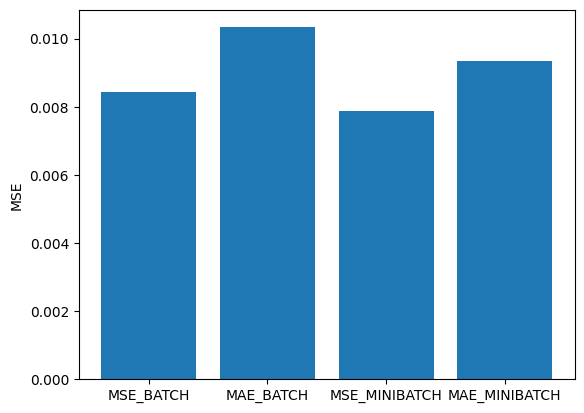

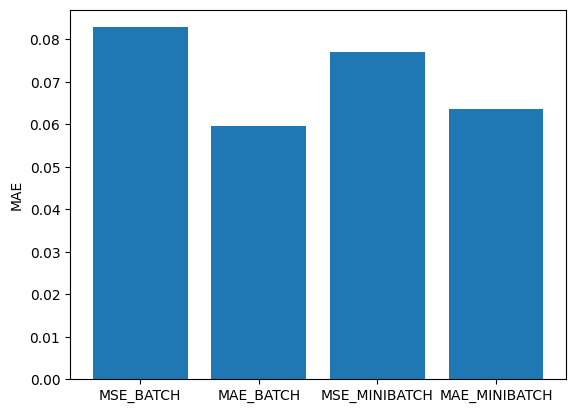

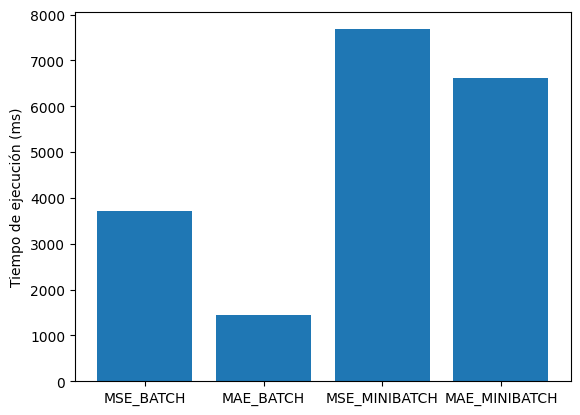

In [24]:
# Ajuste usando batch
mae_errs = []
mse_errs = []
times = []
labels = ['MSE_BATCH','MAE_BATCH','MSE_MINIBATCH','MAE_MINIBATCH']
print("Ajuste usando batch")

modelo = [1,1,1]
print('Ajuste con MSE')
print('Error inicial -> ',MSE(modelo,x,y))
start = time.time()
linear_regression(modelo,x,y,20000,0.001,0,MSE_GRAD,False,False, False)
tiempo = (time.time()-start)*1000
mse = MSE(modelo,x,y)
mae = MAE(modelo,x,y)
print('Error final -> ',mse)
mse_errs.append(mse)
mae_errs.append(mae)
times.append(tiempo)
print(f'Tiempo de ejecución -> {tiempo} ms')
print(modelo)

modelo = [1,1,1]
print('\nAjuste con MAE')
print('Error inicial -> ',MAE(modelo,x,y))
start = time.time()
linear_regression(modelo,x,y,20000,0.001, 0, MAE_GRAD, False, False, False)
tiempo = (time.time()-start)*1000
mse = MSE(modelo,x,y)
mae = MAE(modelo,x,y)
print('Error final -> ',mae)
mse_errs.append(mse)
mae_errs.append(mae)
times.append(tiempo)
print(f'Tiempo de ejecución -> {tiempo} ms')
print(modelo)

# Ajuste usando minibatch

print("\nAjuste usando minibatch")
modelo = [1,1,1]
print('Ajuste con MSE')
print('Error inicial -> ',MSE(modelo,x,y))
start = time.time()
linear_regression(modelo,x,y,20000,0.001,0,MSE_GRAD,False,False, True, 0.2)
tiempo = (time.time()-start)*1000
mse = MSE(modelo,x,y)
mae = MAE(modelo,x,y)
print('Error final -> ',mse)
mse_errs.append(mse)
mae_errs.append(mae)
times.append(tiempo)
print(f'Tiempo de ejecución -> {tiempo} ms')
print(modelo)

modelo = [1,1,1]
print('\nAjuste con MAE')
print('Error inicial -> ',MAE(modelo,x,y))
start = time.time()
linear_regression(modelo,x,y,20000,0.001,0,MAE_GRAD,False,False, True, 0.2)
tiempo = (time.time()-start)*1000
mse = MSE(modelo,x,y)
mae = MAE(modelo,x,y)
print('Error final -> ',mae)
mse_errs.append(mse)
mae_errs.append(mae)
times.append(tiempo)
print(f'Tiempo de ejecución -> {tiempo} ms')
print(modelo)
bar_plot(labels,mse_errs,'Error cuadrado medio (MSE)')
bar_plot(labels,mae_errs,'Error absoluto medio (MAE)')
bar_plot(labels,times,'Tiempo de ejecución (ms)')

#Implementación de términos de regularización L1 y L2; y su prueba con el conjunto *diabetes*

**Importante: Para que estas celdas funcionen se debe de mover el archivo diabetes.tab.txt a la carpeta del cuaderno y cambiar la extensión de .txt a .csv, por lo que el nuevo nombre del dataset sería diabetes.tab.csv**

Transformación del dataset a arrays para que el regresor pueda trabajar con él

In [27]:
data = pd.read_csv('diabetes.tab.csv',delimiter='\t')
def from_dataset_to_arrays(data):
  Y = data['Y']
  y = list(Y.values)
  data = data.drop(columns='Y')
  x = list(data.values)
  for a in range(len(x)):
    b = list(x[a])
    x[a] = b

  return x,y
x,y = from_dataset_to_arrays(data)

Se definen las funciones de error lasso y ridge

In [28]:
def lasso_error(modelo,x,y,reg_term,error_func):

    reg_error = error_func(modelo,x,y)
    L1=0
    for weight in range(len(modelo)-1):
        L1 += abs(modelo[weight])

    return reg_error + L1*reg_term

def ridge_error(modelo,x,y,reg_term,error_func):

    reg_error = error_func(modelo,x,y)
    L2=0
    for weight in range(len(modelo)-1):
        L2 += (modelo[weight])**2

    return reg_error + L2*reg_term

Ajuste lasso y ridge con conjunto de datos diabetes

---Ajuste lasso----
Ajuste con MSE
Error inicial ->  233497.4117060791
Error final ->  51.90044481015456
Tiempo de ejecución -> 26452.08191871643 ms
[0.4370434552865663, 1.3407532092072407, 1.8468275592001382, 1.0910770020224871, -0.2544549150860537, 0.19175036779470525, -1.421864128087265, 1.4813903918901512, 1.4323597942170752, 0.6730688069481767, 0.9806869541857757]

Ajuste con MAE
Error inicial ->  474.21646063348413
Error final ->  46.61932787758637
Tiempo de ejecución -> 23067.175149917603 ms
[-0.17507239819002682, 0.9924434389139652, 3.41808009049828, 1.0500189140270992, 1.6015674208144595, -1.8259809954750963, -2.8643837104078216, 1.4274614479637258, 1.509431608597239, 0.05565158371037011, 0.936647058823495]

---Ajuste ridge:---
Ajuste con MSE
Error inicial ->  233497.4117060791
Error final ->  50.52166334875068
Tiempo de ejecución -> 30113.067150115967 ms
[0.3958404570435124, 2.1269674281365525, 2.7130816722839706, 1.1320858

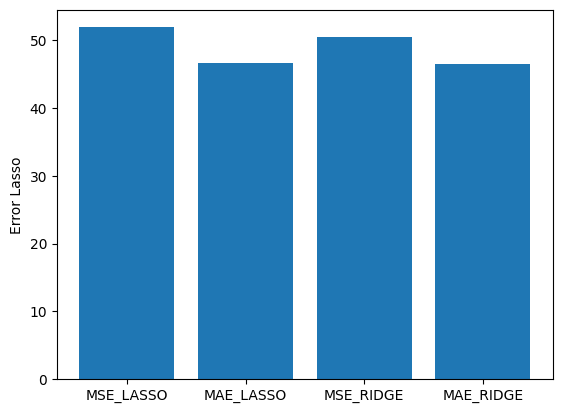

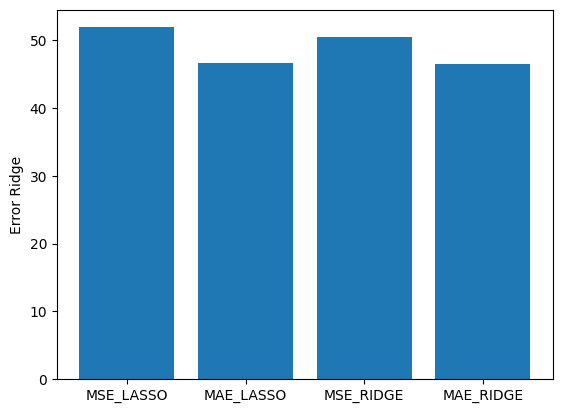

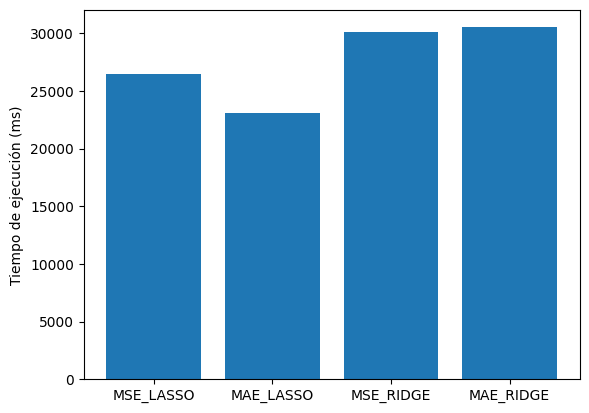

In [38]:
print('Ajuste lasso y ridge con conjunto de datos diabetes')
lasso_errs = []
ridge_errs = []
times = []
labels = ['MSE_LASSO','MAE_LASSO','MSE_RIDGE','MAE_RIDGE']
reg_term = 0.0001

print('\n---Ajuste lasso----')

modelo = []
for i in range(len(x[0])+1):
  modelo.append(1)
print('Ajuste con MSE')
print('Error inicial -> ',lasso_error(modelo,x,y,reg_term,MSE))
start = time.time()
linear_regression(modelo,x,y,4000,0.000001,reg_term, MSE_GRAD, True, False, False)
tiempo = (time.time()-start)*1000
times.append(tiempo)
error_lasso = lasso_error(modelo,x,y,reg_term,MAE)
print('Error final -> ',error_lasso)
lasso_errs.append(error_lasso)

error_ridge = ridge_error(modelo,x,y,reg_term,MAE)
ridge_errs.append(error_ridge)
print(f'Tiempo de ejecución -> {tiempo} ms')
print(modelo)


modelo = []
for i in range(len(x[0])+1):
  modelo.append(1)
print('\nAjuste con MAE')
print('Error inicial -> ',lasso_error(modelo,x,y,reg_term,MAE))
start = time.time()
linear_regression(modelo,x,y,4000,0.001,reg_term,MAE_GRAD,True,False, False)
tiempo = (time.time()-start)*1000
times.append(tiempo)
error_lasso = lasso_error(modelo,x,y,reg_term,MAE)
print('Error final -> ',error_lasso)
lasso_errs.append(error_lasso)

error_ridge = ridge_error(modelo,x,y,reg_term,MAE)
ridge_errs.append(error_ridge)
print(f'Tiempo de ejecución -> {tiempo} ms')
print(modelo)

print('\n---Ajuste ridge:---')

modelo = []
for i in range(len(x[0])+1):
  modelo.append(1)
print('Ajuste con MSE')
print('Error inicial -> ',ridge_error(modelo,x,y,reg_term,MSE))
start = time.time()
linear_regression(modelo,x,y,4000,0.000001,reg_term, MSE_GRAD,False, True, False)
tiempo = (time.time()-start)*1000
times.append(tiempo)
error_ridge = ridge_error(modelo,x,y,reg_term,MAE)
ridge_errs.append(error_ridge)

error_lasso = lasso_error(modelo,x,y,reg_term,MAE)
lasso_errs.append(error_lasso)
print('Error final -> ',error_ridge)

print(f'Tiempo de ejecución -> {tiempo} ms')
print(modelo)


modelo = []
for i in range(len(x[0])+1):
  modelo.append(1)
print('\nAjuste con MAE')
print('Error inicial -> ',ridge_error(modelo,x,y,reg_term,MAE))
start = time.time()
linear_regression(modelo,x,y,4000,0.001,reg_term,MAE_GRAD,False, True, False)
tiempo = (time.time()-start)*1000
times.append(tiempo)
error_ridge = ridge_error(modelo,x,y,reg_term,MAE)
ridge_errs.append(error_ridge)

error_lasso = lasso_error(modelo,x,y,reg_term,MAE)
lasso_errs.append(error_lasso)
print('Error final -> ',error_ridge)
print(f'Tiempo de ejecución -> {tiempo} ms')
print(modelo)

bar_plot(labels,lasso_errs,'Error Lasso')
bar_plot(labels,ridge_errs,'Error Ridge')
bar_plot(labels,times,'Tiempo de ejecución (ms)')

#Prueba utilizando un regresor de la librería *scikit-learn*

In [73]:
#Regresión lineal optimizando con el error cuadrático
reg = linear_model.LinearRegression()
errs = []
lasso_errs = []
ridge_errs = []
elastic_net_errs = [0,0,0]
labels = ['MAE_GRAD','SCIKIT_REGRESOR']
ridge_labels = ['MAE_RIDGE','SCIKIT_RIDGE']
lasso_labels = ['MAE_LASSO','SCIKIT_LASSO']
elastic_net_labels = ['MAE_LASSO','MAE_RIDGE','SCIKIT_ELASTIC_NET']
tiems1 = []
tiems2 = []
tiems3 = []
tiems4 = [0,0,0]
modelo =[]
for i in range(len(x[0])+1):
  modelo.append(1)
start = time.time()
linear_regression(modelo,x,y,4000,0.001,0, MAE_GRAD)
tiempo = (time.time()-start)*1000
errs.append(MAE(modelo,x,y))
tiems1.append(tiempo)


start = time.time()
reg.fit(x, y)
tiempo = (time.time()-start)*1000

prediction = reg.predict(x)
errs.append(mean_absolute_error(y, prediction))
tiems1.append(tiempo)
print('Ajuste con MSE')
print('Error cuadrático -> ',mean_squared_error(y, prediction))
print('Error absoluto -> ', mean_absolute_error(y, prediction))
print(f'Tiempo de ejecución -> {tiempo} ms')
print(f'[{reg.coef_} {reg.intercept_}]')

#Regresión lineal optimizando con el error ridge

modelo = []
for i in range(len(x[0])+1):
  modelo.append(1)
start = time.time()
linear_regression(modelo,x,y,4000,0.001,reg_term,MAE_GRAD,False, True, False)
tiempo = (time.time()-start)*1000
tiems2.append(tiempo)
tiems4[1] = tiempo
ridge_errs.append(MAE(modelo,x,y))
elastic_net_errs[1] = ridge_errs[len(ridge_errs)-1]
reg = linear_model.Ridge()

start = time.time()
reg.fit(x, y)
tiempo = (time.time()-start)*1000
tiems2.append(tiempo)
prediction = reg.predict(x)
ridge_errs.append(mean_absolute_error(y, prediction))
print('\nAjuste con Ridge')
print('Error cuadrático -> ',mean_squared_error(y, prediction))
print('Error absoluto -> ', mean_absolute_error(y, prediction))
print(f'Tiempo de ejecución -> {tiempo} ms')
print(f'[{reg.coef_} {reg.intercept_}]')

#Regresión lineal optimizando con el error lasso
modelo = []
for i in range(len(x[0])+1):
  modelo.append(1)

start = time.time()
linear_regression(modelo,x,y,4000,0.001,reg_term, MAE_GRAD, True, False, False)
tiempo = (time.time()-start)*1000
tiems3.append(tiempo)
tiems4[0] = tiempo
lasso_errs.append(MAE(modelo,x,y))
elastic_net_errs[0] = lasso_errs[len(lasso_errs)-1]

reg = linear_model.Lasso()

start = time.time()
reg.fit(x, y)
tiempo = (time.time()-start)*1000
tiems3.append(tiempo)
prediction = reg.predict(x)
lasso_errs.append(mean_absolute_error(y, prediction))
print('\nAjuste con Lasso')
print('Error cuadrático -> ',mean_squared_error(y, prediction))
print('Error absoluto -> ', mean_absolute_error(y, prediction))
print(f'Tiempo de ejecución -> {tiempo} ms')
print(f'[{reg.coef_} {reg.intercept_}]')

#Regresión lineal optimizando con el error Elastic-Net
reg = linear_model.ElasticNet()

start = time.time()
reg.fit(x, y)
tiempo = (time.time()-start)*1000
tiems4[2] = tiempo
prediction = reg.predict(x)
elastic_net_errs[2] = mean_absolute_error(y, prediction)
print('\nAjuste con Elastic-Net')
print('Error cuadrático -> ',mean_squared_error(y, prediction))
print('Error absoluto -> ', mean_absolute_error(y, prediction))
print(f'Tiempo de ejecución -> {tiempo} ms')
print(f'[{reg.coef_} {reg.intercept_}]')

Ajuste con MSE
Error cuadrático ->  2859.6963475867506
Error absoluto ->  43.27745202531506
Tiempo de ejecución -> 2.709627151489258 ms
[[-3.63612242e-02 -2.28596481e+01  5.60296209e+00  1.11680799e+00
 -1.08999633e+00  7.46450456e-01  3.72004715e-01  6.53383194e+00
  6.84831250e+01  2.80116989e-01] -334.5671385187875]

Ajuste con Ridge
Error cuadrático ->  2860.471596894782
Error absoluto ->  43.29169564350627
Tiempo de ejecución -> 1.7709732055664062 ms
[[-3.28523969e-02 -2.26070454e+01  5.64040523e+00  1.11899757e+00
 -9.14673484e-01  5.84909825e-01  1.77885238e-01  6.25044178e+00
  6.31790809e+01  2.87766903e-01] -316.07711860428856]

Ajuste con Lasso
Error cuadrático ->  2901.5847284544093
Error absoluto ->  43.79459928373489
Tiempo de ejecución -> 3.994464874267578 ms
[[-1.90267115e-02 -1.74770497e+01  5.84243057e+00  1.09154258e+00
  1.56132396e-01 -3.15203518e-01 -1.18775171e+00  1.62432746e-01
  3.42247151e+01  3.29732281e-01] -202.30265547056504]

Ajuste con Elastic-Net
Error

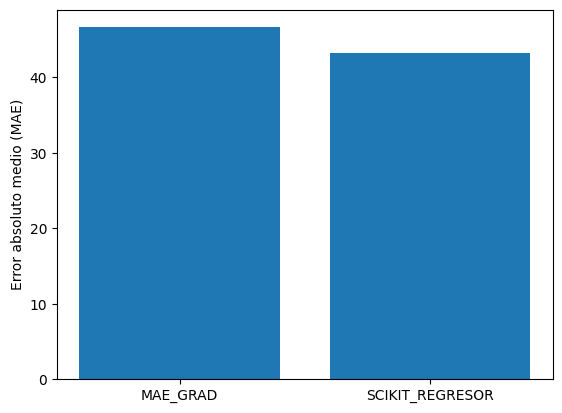

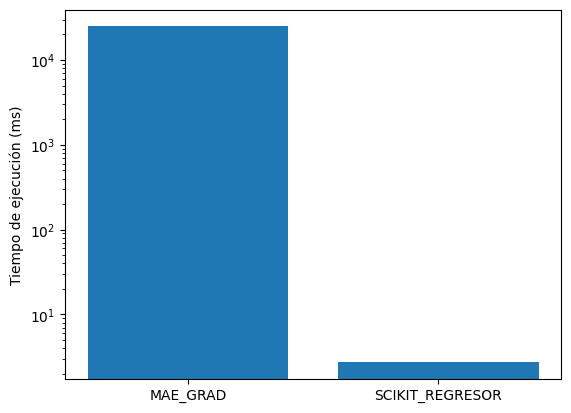

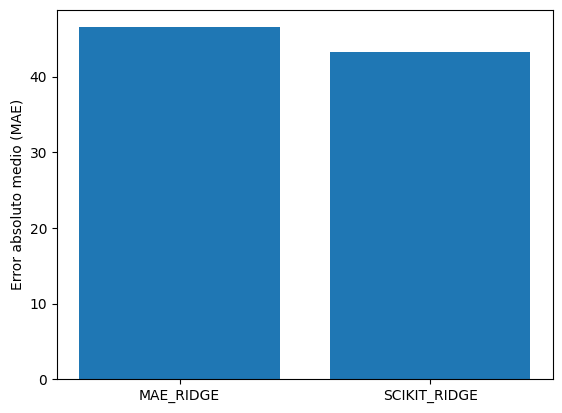

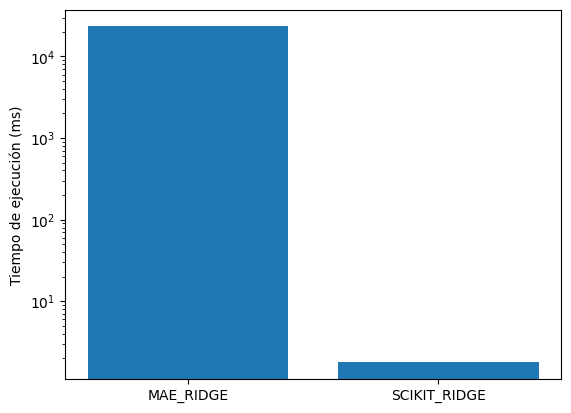

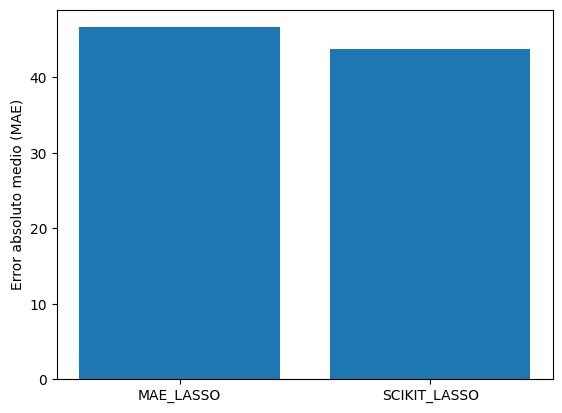

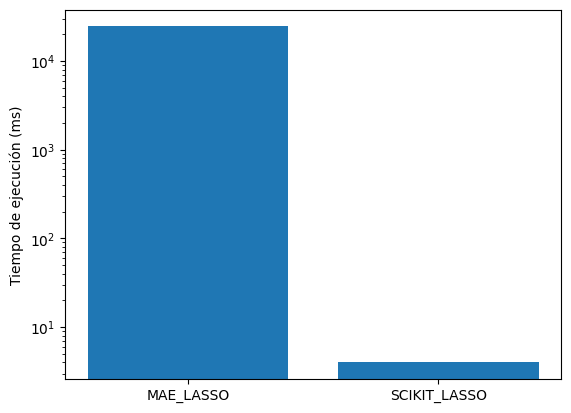

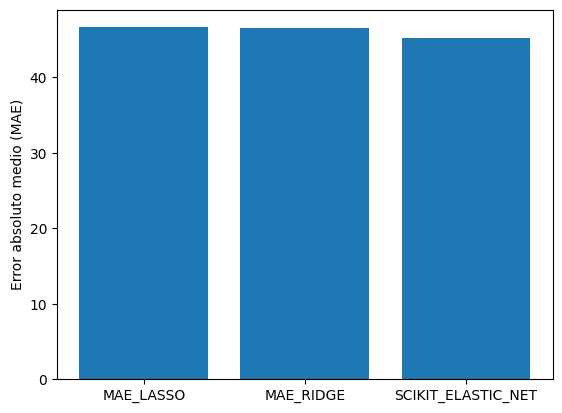

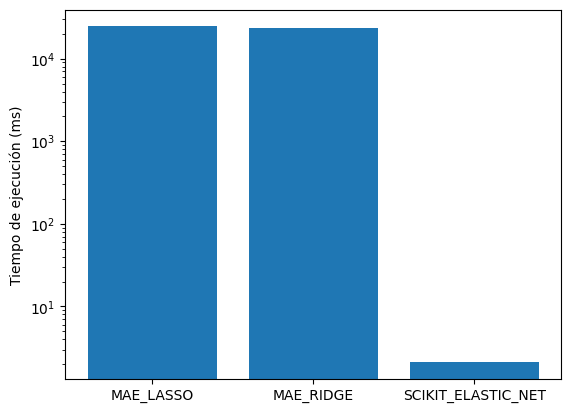

In [74]:
bar_plot(labels,errs,'Error absoluto medio (MAE)')
bar_plot(labels,tiems1,'Tiempo de ejecución (ms)','',True)

bar_plot(ridge_labels,ridge_errs,'Error absoluto medio (MAE)')
bar_plot(ridge_labels,tiems2,'Tiempo de ejecución (ms)','',True)

bar_plot(lasso_labels,lasso_errs,'Error absoluto medio (MAE)')
bar_plot(lasso_labels,tiems3,'Tiempo de ejecución (ms)','',True)

bar_plot(elastic_net_labels,elastic_net_errs,'Error absoluto medio (MAE)')
bar_plot(elastic_net_labels,tiems4,'Tiempo de ejecución (ms)','',True)